# Example of usage Spark OCR for Signature Detection

## Install spark-ocr python packge
Need to specify:
- secret
- license
- aws credentials

In [1]:
secret = ""
license = ""
AWS_ACCESS_KEY_ID = ""
AWS_SECRET_ACCESS_KEY = ""

version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.11"
imagePath = "./data/signature/LIL18369-Lease_Z-1.jpg"

In [ ]:
%%bash
if python -c 'import google.colab' &> /dev/null; then
    echo "Run on Google Colab!"
    echo "Install Open JDK"
    apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
    java -version
fi

In [ ]:
import os
import sys

if AWS_ACCESS_KEY_ID != "":
    os.environ["AWS_ACCESS_KEY_ID"] = AWS_ACCESS_KEY_ID
    os.environ["AWS_SECRET_ACCESS_KEY"] = AWS_SECRET_ACCESS_KEY
    
if license:
    os.environ['JSL_OCR_LICENSE'] = license
    
if 'google.colab' in sys.modules:
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

In [ ]:
#%pip install ../../python/dist/spark-ocr-3.3.0.spark24.tar.gz

## Initialization of spark session
Need specify path to `spark-ocr-assembly.jar` or `secret`

In [5]:
from pyspark import SparkConf
from sparkocr import start

spark = start(secret=secret, jar_path = spark_ocr_jar_path, nlp_version="3.0.0")

spark

Spark version: 2.4.7
Spark NLP version: 2.5.5
Spark OCR version: 3.3.0



## Read images and display it


    Image #0:
    Origin: file:/Users/chico/IdeaProjects/spark-ocr/workshop/jupyter/data/signature/LIL18369-Lease_Z-1.jpg
    Resolution: 0 dpi
    Width: 612 px
    Height: 792 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


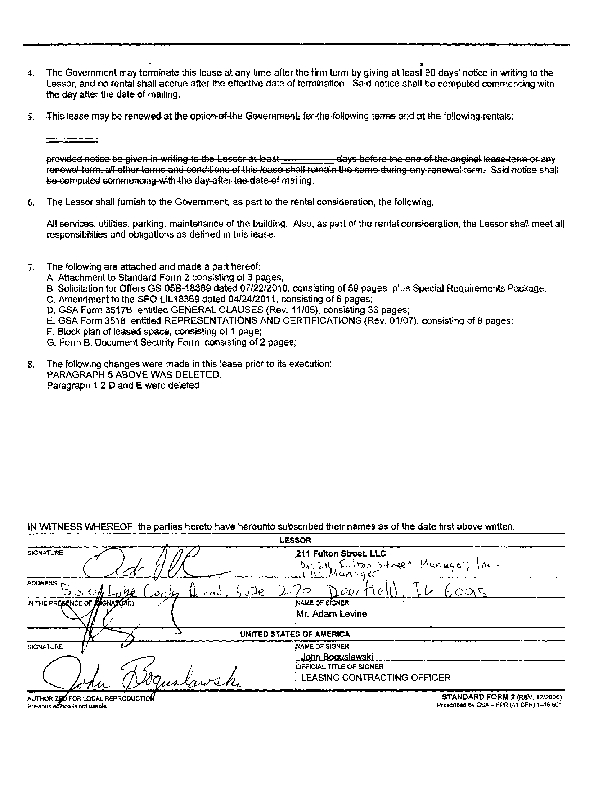

In [6]:
from pyspark.ml import PipelineModel
import pyspark.sql.functions as f
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_images

image_df = spark.read.format("binaryFile").load(imagePath)

display_images(BinaryToImage().transform(image_df), "image")

## Define OCR Pipeline

In [7]:
binary_to_image = BinaryToImage()
binary_to_image.setImageType(ImageType.TYPE_3BYTE_BGR)

pretrained_model = ("image_signature_detector_gsa0611", "en", "public/ocr/models")
signature_detector = ImageSignatureDetector() \
    .pretrained(*pretrained_model) \
    .setInputCol("image") \
    .setOutputCol("signature_regions")

draw_regions = ImageDrawRegions()
draw_regions.setInputCol("image")
draw_regions.setInputRegionsCol("signature_regions")
draw_regions.setOutputCol("image_with_regions")

pipeline = PipelineModel(stages=[
    binary_to_image,
    signature_detector,
    draw_regions
])

image_signature_detector_gsa0611 download started this may take some time.
Approximate size to download 247.1 MB


## Run pipeline and show results


    Image #0:
    Origin: file:/Users/chico/IdeaProjects/spark-ocr/workshop/jupyter/data/signature/LIL18369-Lease_Z-1.jpg
    Resolution: 0 dpi
    Width: 612 px
    Height: 792 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


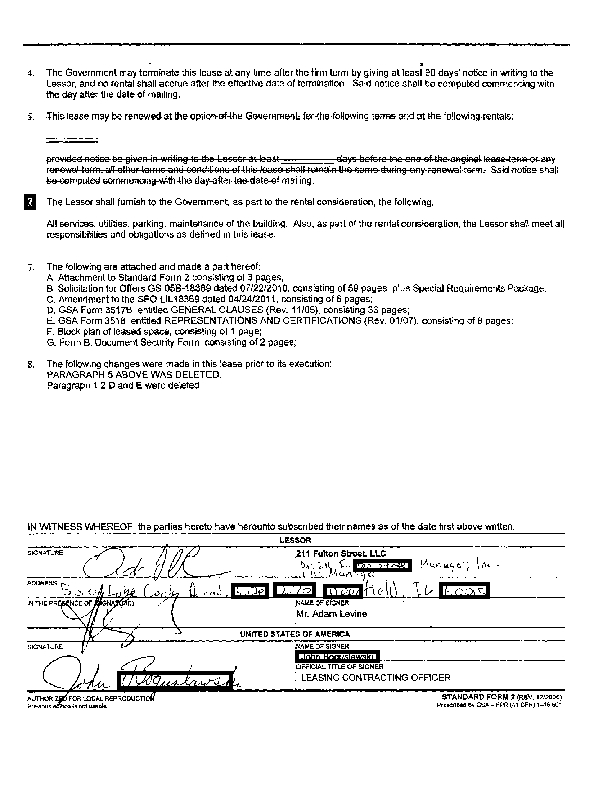

In [8]:
result =  pipeline.transform(image_df)
display_images(result, "image_with_regions")

In [10]:
result.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = false)
 |    |-- width: integer (nullable = false)
 |    |-- nChannels: integer (nullable = false)
 |    |-- mode: integer (nullable = false)
 |    |-- resolution: integer (nullable = false)
 |    |-- data: binary (nullable = true)
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- pagenum: integer (nullable = true)
 |-- signature_regions: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- index: integer (nullable = false)
 |    |    |-- page: integer (nullable = false)
 |    |    |-- x: float (nullable = false)
 |    |    |-- y: float (nullable = false)
 |    |    |-- width: float (nullable = false)
 |    |    |-- height: float (nullable = false)
 |    |    |-- score: float (nullable = true)
 |    |    |-- label: integer (nullable = true)
 |-- image_wit

In [11]:
result = result.withColumn("coordinate", f.explode(f.col("signature_regions"))).select("coordinate")


In [12]:
result = result.where(f.col("coordinate").isNotNull())


In [15]:
result.show(truncate=False)

+-----------------------------------------------+
|coordinate                                     |
+-----------------------------------------------+
|[0, 0, 297.0, 652.0, 81.0, 9.0, 0.9158211, 1]  |
|[1, 0, 325.0, 586.0, 36.0, 11.0, 0.9130365, 1] |
|[2, 0, 233.0, 585.0, 34.0, 12.0, 0.86913645, 1]|
|[3, 0, 26.0, 196.0, 8.0, 12.0, 0.7372417, 0]   |
|[4, 0, 441.0, 584.0, 47.0, 13.0, 0.7115546, 1] |
|[5, 0, 355.0, 561.0, 55.0, 9.0, 0.6475877, 1]  |
|[6, 0, 119.0, 673.0, 112.0, 15.0, 0.5111962, 1]|
|[7, 0, 275.0, 584.0, 39.0, 12.0, 0.5003116, 1] |
+-----------------------------------------------+



In [14]:
result.count()

8

In [13]:
assert( result.count() > 0 )